In [ ]:
## Plotting ualong decomposed into eddy and rolling mean fields

In [1]:
import os

import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import cmocean as cm
from xgcm import Grid
import glob

import matplotlib.dates as mdates
import datetime
import pandas as pd

In [2]:
%matplotlib inline

In [3]:
from matplotlib import rc
rc('font', **{'size':25})
rc('text', usetex=False)
rc('xtick', labelsize=25) #20 
rc('ytick', labelsize=25) #20
rc('axes', titlesize=25)    # fontsize of the axes title
rc('axes', labelsize=25) #24    # fontsize of the x and y labels

In [4]:
session=cc.database.create_session()

exp_ctrl= '01deg_jra55v13_ryf9091'
exp_wthmp= '01deg_jra55v13_ryf9091_qian_wthmp'
exp_wthp= '01deg_jra55v13_ryf9091_qian_wthp'
lat_lim = slice(-79, -60)
lon_lim = slice(-279.99,80)

#### SET EXPT HERE
expt = exp_wthmp


In [5]:
# We will use an annual average from 10 year in the RYF run
start_time_mw='2110-01-31 00:00:00' 
end_time_mw='2159-12-31 00:00:00'


In [76]:
import dask.config
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

walltime = '01:00:00'
cores = 28

memory = '252GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory),processes=cores,
                     job_extra=['-q normalbw','-P v45','-l ncpus='+str(cores),'-l mem='+str(memory),
                                '-l storage=gdata/ik11+gdata/e14+gdata/hh5+gdata/v45+gdata/cj50',
                                '-l jobfs=400GB'],
                     local_directory='$TMPDIR',
                     header_skip=["select"],
                     #python=os.environ["DASK_PYTHON"]
                    )
cluster

# and if you want even more power, you can use this to make it three nodes
cluster.scale(jobs=3)

# then, run this to make a dask client

c = Client(cluster)
c

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/35035/status,
Dashboard: /proxy/35035/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.1:42745,Workers: 0
Dashboard: /proxy/35035/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [7]:
## load variables

In [7]:
hu = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='hu', 
                          session=session, frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1).sel(yu_ocean = slice(-79,-60))

In [8]:
u = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/u_monthly_field' + expt +'.nc').ug_s
v = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/v_monthly_field' + expt +'.nc').vg_s

In [9]:
mask_shelf = xr.where(hu<1000 , True, False)
mask_slope = xr.where(hu>1000, True, False)

In [10]:
# defining B-grid using xgcm
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
ocean_grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

In [11]:
## plotting everything together
cluster_mask_access = xr.open_mfdataset('Antarctic-Eddy-Res-Compare/largest_3cluster_mask_xr_accessom201.nc')
#calculating area on shelf and slope total
area_u = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='area_u', 
                          session=session, frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1).sel(xu_ocean= lon_lim, yu_ocean = lat_lim)
circ_area_slope = (area_u*cluster_mask_access.where(mask_slope ==True)).sum().__xarray_dataarray_variable__.values                                                                                                                                                                                           
circ_area_shelf = (area_u*cluster_mask_access.where(mask_shelf ==True)).sum().__xarray_dataarray_variable__.values                                                                                                                                                                                           
circ_area_total = (area_u*cluster_mask_access).sum().__xarray_dataarray_variable__.values                                                                                                                                                                                           


In [12]:
# NEEDload coordinates and grid specifications
geolat_t = cc.querying.getvar(expt, 'geolat_t', session=session, n=1)
geolon_t = cc.querying.getvar(expt, 'geolon_t', session=session, n=1)

dxt = cc.querying.getvar(expt=expt, variable='dxt', session=session, frequency='static', n=1)
dyt = cc.querying.getvar(expt=expt, variable='dyt', session=session, frequency='static', n=1)

dxu = cc.querying.getvar(expt=expt, variable='dxu', session=session, frequency='static', n=1)
dyu = cc.querying.getvar(expt=expt, variable='dyu', session=session, frequency='static', n=1)

In [13]:
#sea_level_lim = sea_level.sel( xt_ocean= lon_lim, yt_ocean=lat_lim, time = flex_period)

# coordinates
lat_t = geolat_t.sel( xt_ocean= lon_lim,yt_ocean=lat_lim)
lon_t = geolon_t.sel(xt_ocean= lon_lim, yt_ocean=lat_lim)

dxt_lim = dxt.sel(xt_ocean= lon_lim,yt_ocean=lat_lim)
dyt_lim = dyt.sel(xt_ocean= lon_lim,yt_ocean=lat_lim)

dxu_lim = dxu.sel(xu_ocean= lon_lim,yu_ocean=lat_lim)
dyu_lim = dyu.sel(xu_ocean= lon_lim,yu_ocean=lat_lim)

In [14]:
## need to run seperately or it will crash
import xgcm
coordinates = xr.merge([dxt_lim, dyt_lim, dxu_lim, dyu_lim])

In [15]:
vel = xr.merge([hu,coordinates, u, v, ocean_grid.sel(xt_ocean= lon_lim,xu_ocean= lon_lim, yt_ocean=lat_lim, yu_ocean = lat_lim).isel(time = 0)],compat='override')# time is flex_period before

In [16]:
vel.coords['xt_ocean'].attrs.update(axis='X')
vel.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5, periodic=True)
vel.coords['yt_ocean'].attrs.update(axis='Y')
vel.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
metrics = {
    ('X',): ['dxt', 'dxu'], # X distances
    ('Y',): ['dyt', 'dyu'], # Y distances
    ('X', 'Y'): ['area_t', 'area_u'] # Areas
}

In [17]:
grid = xgcm.Grid(vel, periodic=['X'], metrics = metrics,boundary='extend')
grid

<xgcm.Grid>
X Axis (periodic, boundary='extend'):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary='extend'):
  * center   yt_ocean --> right
  * right    yu_ocean --> center

In [18]:
# Take gradient and move to u grid
# Simple gradient over one grid cell. 
# In latitudinal direction, we need to specify what happens at the boundary.
dhu_dx = grid.interp( grid.diff(vel.hu, 'X') / grid.interp(vel.dxu, 'X'), 'X')#, 'Y', boundary='extend')
dhu_dy = grid.interp( grid.diff(vel.hu, 'Y', boundary='extend') / grid.interp(vel.dyt, 'X'), 'Y', boundary='extend')# 'X')
dhu_dx

<xarray.DataArray (yu_ocean: 440, xu_ocean: 3600)> Size: 6MB
dask.array<interp_center_to_right, shape=(440, 3600), dtype=float32, chunksize=(440, 900), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02

In [19]:
# Calculate the magnitude of the topographic slope
slope = np.sqrt(dhu_dx**2 + dhu_dy**2).rename('slope')

In [20]:
def calc_u_along_integral_mask_tt(tt, chunk_size, mask_region, u_input, v_input):
    u_t = u_input.isel(time = slice(tt*chunk_size, chunk_size*(tt+1))).where(cluster_mask_access == True).where(mask_region == True).load()
    v_t = v_input.isel(time = slice(tt*chunk_size, chunk_size*(tt+1))).where(cluster_mask_access == True).where(mask_region == True).load()
    
    u_comp = (u_t*dhu_dy/slope).__xarray_dataarray_variable__#.compute()
    v_comp = (v_t*dhu_dx/slope).__xarray_dataarray_variable__#.compute()
    u_along = u_comp.chunk({ 'yu_ocean':100, 'xu_ocean':50}) - v_comp.chunk({ 'yu_ocean':100, 'xu_ocean':50})
    u_along_tt = grid.integrate(u_along, axis = {'X', 'Y'}).load()#.values
    print(tt)
    return u_along_tt

In [21]:
import gc

In [22]:
windows= 120

In [23]:
cluster_mask_access= cluster_mask_access.assign_coords(xu_ocean = ('xu_ocean', u.xu_ocean.data), yu_ocean = ('yu_ocean', u.yu_ocean.data))

In [25]:
FileList = ['/g/data/v45/qo9901/MW-perturb-ASC-data/u_rolling_mean_W' + str(windows) + '_' + expt +'_' + str(xx_file) + '.nc' for xx_file in range(4)]
u_reshape = xr.open_mfdataset(FileList, combine = 'by_coords').__xarray_dataarray_variable__
FileList = ['/g/data/v45/qo9901/MW-perturb-ASC-data/v_rolling_mean_W' + str(windows) + '_' + expt +'_' + str(xx_file) + '.nc' for xx_file in range(4)]
v_reshape = xr.open_mfdataset(FileList, combine = 'by_coords').__xarray_dataarray_variable__


In [34]:
chunksize = 37

In [39]:
%%time
#u_transient_clim = u.isel(xu_ocean = slice(xx*300 + 900*xx_file, (xx+1)*300+ 900*xx_file)) - u_reshape.isel(xu_ocean = slice(xx*300, (xx+1)*300))
#v_transient_clim = v.isel(xu_ocean = slice(xx*300+ 900*xx_file, (xx+1)*300+ 900*xx_file)) - v_reshape.isel(xu_ocean = slice(xx*300, (xx+1)*300))
u_along_eddy_slopematrix =[]
u_along_eddy_shelfmatrix = []
for tt in range(13):
    u_transient_clim = u.isel(time = slice(60+tt*chunksize, 60+(tt+1)*chunksize)) - u_reshape.isel(time = slice(tt*chunksize, (tt+1)*chunksize))
    v_transient_clim = v.isel(time = slice(60+tt*chunksize, 60+(tt+1)*chunksize)) - v_reshape.isel(time = slice(tt*chunksize, (tt+1)*chunksize))
    
    print('loading')
    u_transientsel = u_transient_clim.assign_coords(time = v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]).load()#.expand_dims(time = {v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]:chunksize}).load()#.where(mask_bath_shelf == True)
    c.run(gc.collect)
    
    v_transientsel = v_transient_clim.assign_coords(time = v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]).load()#.expand_dims(time = {v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]:chunksize}).load()#.where(mask_bath_shelf == True)
    
    u_along_eddy_slope = calc_u_along_integral_mask_tt(0, chunksize, mask_slope, u_transientsel, v_transientsel)  
    u_along_eddy_slopematrix.append(u_along_eddy_slope)
    u_along_eddy_shelf = calc_u_along_integral_mask_tt(0, chunksize, mask_shelf, u_transientsel, v_transientsel)  
    u_along_eddy_shelfmatrix.append(u_along_eddy_shelf)
    del u_along_eddy_slope, u_along_eddy_shelf
    print('tt = ' + str(tt))


loading
0
0
tt = 0
loading
0
0
tt = 1
loading
0
0
tt = 2
loading
0
0
tt = 3
loading
0
0
tt = 4
loading
0
0
tt = 5
loading
0
0
tt = 6
loading
0
0
tt = 7
loading
0
0
tt = 8
loading
0
0
tt = 9
loading
0
0
tt = 10
loading
0
0
tt = 11
loading
0
0
tt = 12
CPU times: user 4min 58s, sys: 5min 29s, total: 10min 28s
Wall time: 15min 4s


In [36]:
chunksize

37

In [33]:
circ_area_slope, circ_area_shelf

(array(9.95782288e+11), array(2.92146298e+12))

In [40]:
u_along_eddy_slopex = xr.merge([u_along_eddy_slopematrix[i].rename('ualong_eddy') for i in np.arange(int(len(u_along_eddy_slopematrix)))])/circ_area_slope        
u_along_eddy_shelfx = xr.merge([u_along_eddy_shelfmatrix[i].rename('ualong_eddy') for i in np.arange(int(len(u_along_eddy_shelfmatrix)))])/circ_area_shelf                                 

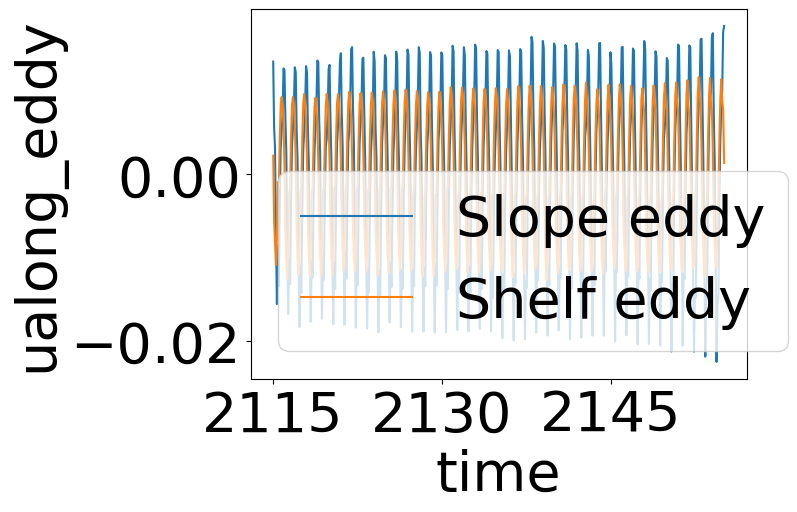

In [41]:
u_along_eddy_slopex.ualong_eddy.plot(label = 'Slope eddy')
u_along_eddy_shelfx.ualong_eddy.plot(label = 'Shelf eddy')
plt.legend()

In [42]:
u_along_eddy_shelfx.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/u_along_rolling_EDDY_W' \
                              + str(windows) + '_' + expt+ 'shelf.nc')
u_along_eddy_slopex.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/u_along_rolling_EDDY_W' \
                              + str(windows) + '_' + expt+ 'slope.nc')

In [44]:

U_ALONG_SHELF_wthmp = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/ualong_monthly_tt_' + exp_wthmp +'_shelf.nc')/circ_area_shelf
U_ALONG_SHELF_wthp = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/ualong_monthly_tt_' + exp_wthp +'_shelf.nc')/circ_area_shelf
U_ALONG_SHELF_ctrl = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/ualong_monthly_tt_' + exp_ctrl +'_shelf.nc')/circ_area_shelf

U_ALONG_SLOPE_wthmp = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/ualong_monthly_tt_' + exp_wthmp +'_slope.nc')/circ_area_slope
U_ALONG_SLOPE_wthp = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/ualong_monthly_tt_' + exp_wthp +'_slope.nc')/circ_area_slope
U_ALONG_SLOPE_ctrl = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/ualong_monthly_tt_' + exp_ctrl +'_slope.nc')/circ_area_slope

In [45]:
U_ALONG_SHELF_wthmp

<xarray.Dataset> Size: 10kB
Dimensions:  (time: 600)
Coordinates:
  * time     (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
Data variables:
    u_along  (time) float64 5kB dask.array<chunksize=(600,), meta=np.ndarray>

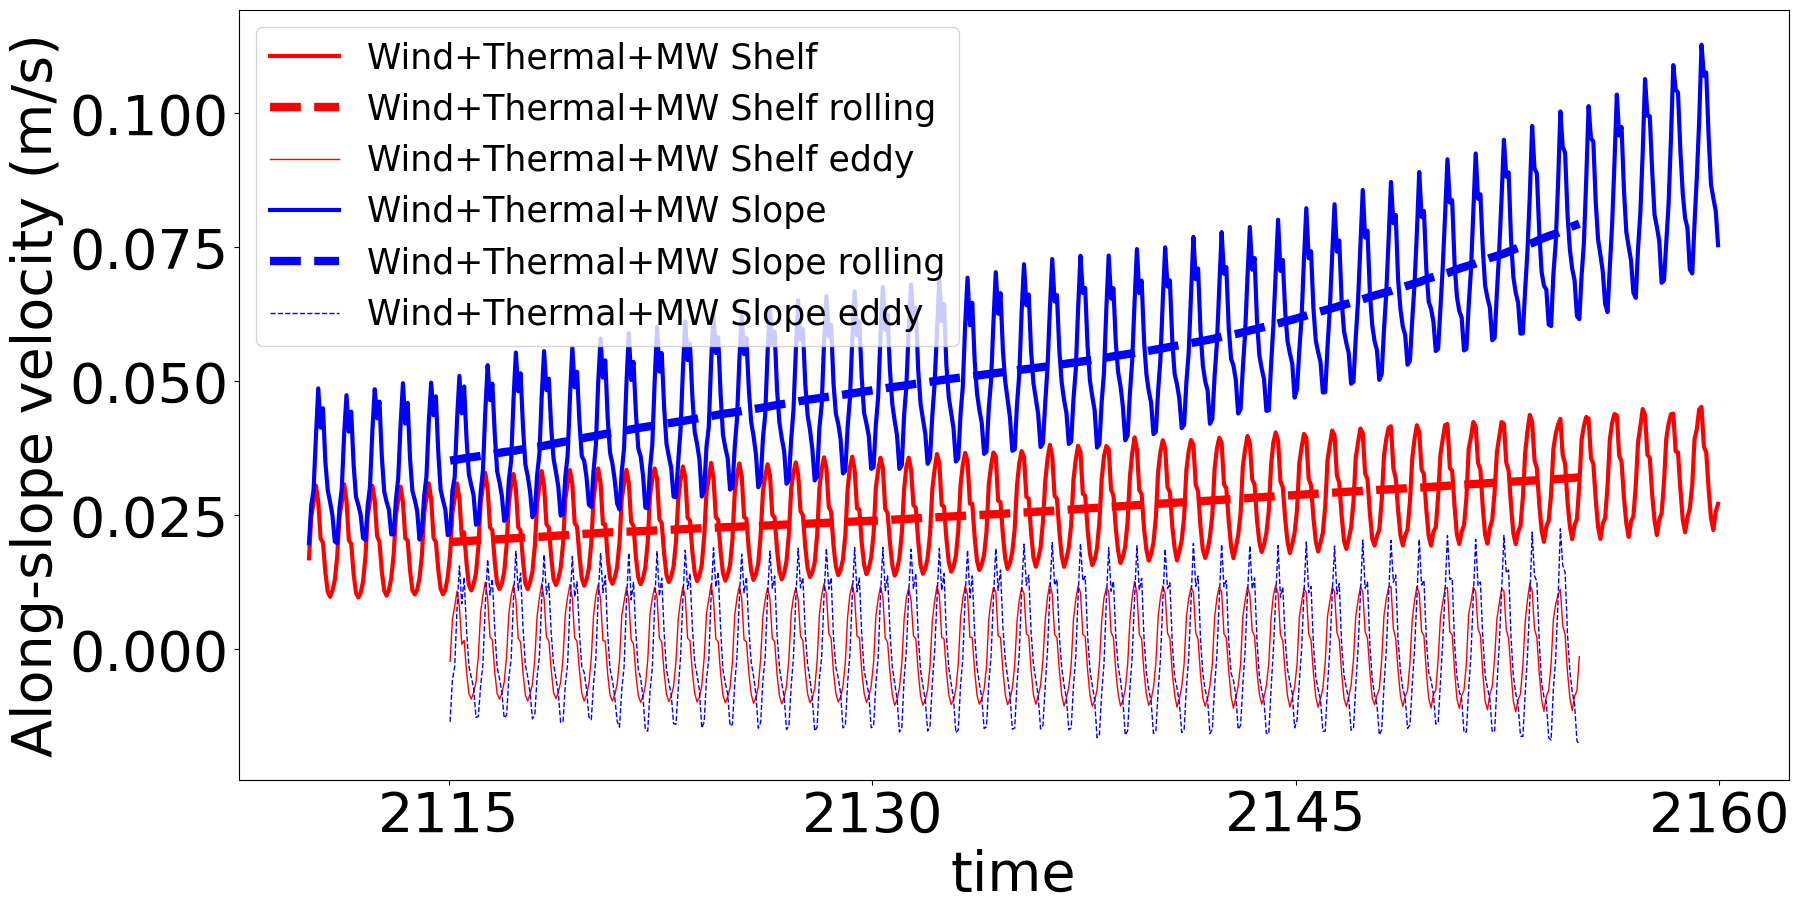

In [50]:
plt.figure(figsize = (20,10))
(-U_ALONG_SHELF_wthmp).u_along.plot( label = 'Wind+Thermal+MW Shelf', color = 'r',lw =3)
(-U_ALONG_SHELF_wthmp).rolling(time = windows, center = True).mean().u_along.plot( label = 'Wind+Thermal+MW Shelf rolling', linestyle = 'dashed',  color = 'r', lw = 6)
(- u_along_eddy_shelfx.ualong_eddy).plot( label = 'Wind+Thermal+MW Shelf eddy', color = 'r', lw =1)

(-U_ALONG_SLOPE_wthmp).u_along.plot( label = 'Wind+Thermal+MW Slope',color = 'b', lw =3)
(-U_ALONG_SLOPE_wthmp).rolling(time = windows, center = True).mean().u_along.plot( label = 'Wind+Thermal+MW Slope rolling', linestyle = 'dashed', color = 'b', lw =6)
(- u_along_eddy_slopex.ualong_eddy).plot( label = 'Wind+Thermal+MW Slope eddy', linestyle = 'dashed', color = 'b', lw =1)

plt.ylabel('Along-slope velocity (m/s)')
plt.legend(fontsize = 25)
#plt.ylim([0,0.17])

## trying to decompose speed instead of along-slope velocity

In [53]:
FileList = ['/g/data/v45/qo9901/MW-perturb-ASC-data/u_rolling_mean_W' + str(windows) + '_' + expt +'_' + str(xx_file) + '.nc' for xx_file in range(4)]
u_reshape = xr.open_mfdataset(FileList, combine = 'by_coords').__xarray_dataarray_variable__
FileList = ['/g/data/v45/qo9901/MW-perturb-ASC-data/v_rolling_mean_W' + str(windows) + '_' + expt +'_' + str(xx_file) + '.nc' for xx_file in range(4)]
v_reshape = xr.open_mfdataset(FileList, combine = 'by_coords').__xarray_dataarray_variable__


In [54]:
chunksize = 13

In [35]:
%%time
#u_transient_clim = u.isel(xu_ocean = slice(xx*300 + 900*xx_file, (xx+1)*300+ 900*xx_file)) - u_reshape.isel(xu_ocean = slice(xx*300, (xx+1)*300))
#v_transient_clim = v.isel(xu_ocean = slice(xx*300+ 900*xx_file, (xx+1)*300+ 900*xx_file)) - v_reshape.isel(xu_ocean = slice(xx*300, (xx+1)*300))
speed_mean_slopematrix =[]
speed_mean_shelfmatrix = []
for tt in range(37):
    u_transient_clim = u_reshape.isel(time = slice(tt*chunksize, (tt+1)*chunksize))
    v_transient_clim = v_reshape.isel(time = slice(tt*chunksize, (tt+1)*chunksize))
    
    print('loading')
    u_transientsel = u_transient_clim.assign_coords(time = v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]).load()#.expand_dims(time = {v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]:chunksize}).load()#.where(mask_bath_shelf == True)
    c.run(gc.collect)
    
    v_transientsel = v_transient_clim.assign_coords(time = v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]).load()#.expand_dims(time = {v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]:chunksize}).load()#.where(mask_bath_shelf == True)
    
    speed_mean_slope = np.sqrt(u_transientsel.where(cluster_mask_access == True).where(mask_slope == True)**2 \
                    +  v_transientsel.where(cluster_mask_access == True).where(mask_slope == True)**2)
    speed_mean_slopematrix.append(grid.integrate(speed_mean_slope, axis = {'X','Y'}).load())
    
    speed_mean_shelf = np.sqrt(u_transientsel.where(cluster_mask_access == True).where(mask_shelf == True)**2 \
                    +  v_transientsel.where(cluster_mask_access == True).where(mask_shelf == True)**2)
    speed_mean_shelfmatrix.append(grid.integrate(speed_mean_shelf, axis = {'X','Y'}).load())
    
    del speed_mean_slope, speed_mean_shelf
    print('tt = ' + str(tt))


loading
tt = 0
loading
tt = 1
loading
tt = 2
loading
tt = 3
loading
tt = 4
loading
tt = 5
loading
tt = 6
loading
tt = 7
loading
tt = 8
loading
tt = 9
loading
tt = 10
loading
tt = 11
loading
tt = 12
loading
tt = 13
loading
tt = 14
loading
tt = 15
loading
tt = 16
loading
tt = 17
loading
tt = 18
loading
tt = 19
loading
tt = 20
loading
tt = 21
loading
tt = 22
loading
tt = 23
loading
tt = 24
loading
tt = 25
loading
tt = 26
loading
tt = 27
loading
tt = 28
loading
tt = 29
loading
tt = 30
loading
tt = 31
loading
tt = 32
loading
tt = 33
loading
tt = 34
loading
tt = 35
loading
tt = 36
CPU times: user 2min 24s, sys: 13min 33s, total: 15min 57s
Wall time: 17min 27s


In [36]:
speed_mean_slopematrix[0].rename_vars({'__xarray_dataarray_variable__':'speed_mean'})

<xarray.Dataset> Size: 208B
Dimensions:     (time: 13)
Coordinates:
  * time        (time) object 104B 2115-01-16 12:00:00 ... 2116-01-16 12:00:00
Data variables:
    speed_mean  (time) float64 104B 5.483e+10 5.487e+10 ... 5.549e+10 5.555e+10

In [37]:
speed_mean_slopex = xr.merge([speed_mean_slopematrix[i].rename_vars({'__xarray_dataarray_variable__':'speed_mean'}) for i in np.arange(int(len(speed_mean_slopematrix)))])/circ_area_slope        
speed_mean_shelfx = xr.merge([speed_mean_shelfmatrix[i].rename_vars({'__xarray_dataarray_variable__':'speed_mean'}) for i in np.arange(int(len(speed_mean_shelfmatrix)))])/circ_area_shelf                                 

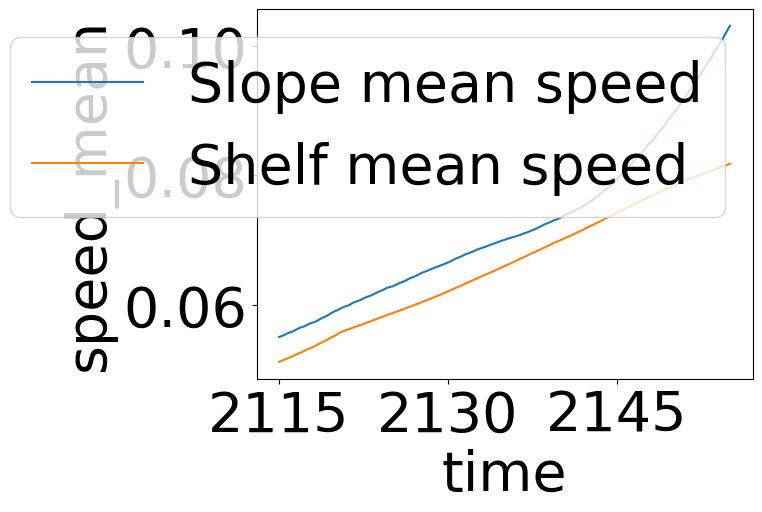

In [38]:
speed_mean_slopex.speed_mean.plot(label = 'Slope mean speed')
speed_mean_shelfx.speed_mean.plot(label = 'Shelf mean speed')
plt.legend()

In [83]:
%%time
#u_transient_clim = u.isel(xu_ocean = slice(xx*300 + 900*xx_file, (xx+1)*300+ 900*xx_file)) - u_reshape.isel(xu_ocean = slice(xx*300, (xx+1)*300))
#v_transient_clim = v.isel(xu_ocean = slice(xx*300+ 900*xx_file, (xx+1)*300+ 900*xx_file)) - v_reshape.isel(xu_ocean = slice(xx*300, (xx+1)*300))
energy_mean_slopematrix =[]
energy_mean_shelfmatrix = []
for tt in range(37):
    u_transient_clim = u_reshape.isel(time = slice(tt*chunksize, (tt+1)*chunksize))
    v_transient_clim = v_reshape.isel(time = slice(tt*chunksize, (tt+1)*chunksize))
    
    print('loading')
    u_transientsel = u_transient_clim.assign_coords(time = v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]).load()#.expand_dims(time = {v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]:chunksize}).load()#.where(mask_bath_shelf == True)
    c.run(gc.collect)
    
    v_transientsel = v_transient_clim.assign_coords(time = v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]).load()#.expand_dims(time = {v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]:chunksize}).load()#.where(mask_bath_shelf == True)
    
    energy_mean_slope = (u_transientsel.where(cluster_mask_access == True).where(mask_slope == True)**2 \
                    +  v_transientsel.where(cluster_mask_access == True).where(mask_slope == True)**2)
    energy_mean_slopematrix.append(grid.integrate(energy_mean_slope, axis = {'X','Y'}).load())
    
    energy_mean_shelf = (u_transientsel.where(cluster_mask_access == True).where(mask_shelf == True)**2 \
                    +  v_transientsel.where(cluster_mask_access == True).where(mask_shelf == True)**2)
    energy_mean_shelfmatrix.append(grid.integrate(energy_mean_shelf, axis = {'X','Y'}).load())
    
    del energy_mean_slope, energy_mean_shelf
    print('tt = ' + str(tt))


loading
tt = 0
loading
tt = 1
loading
tt = 2
loading
tt = 3
loading
tt = 4
loading
tt = 5
loading
tt = 6
loading
tt = 7
loading
tt = 8
loading
tt = 9
loading
tt = 10
loading
tt = 11
loading
tt = 12
loading
tt = 13
loading
tt = 14
loading
tt = 15
loading
tt = 16
loading
tt = 17
loading
tt = 18
loading
tt = 19
loading
tt = 20
loading
tt = 21
loading
tt = 22
loading
tt = 23
loading
tt = 24
loading
tt = 25
loading
tt = 26
loading
tt = 27
loading
tt = 28
loading
tt = 29
loading
tt = 30
loading
tt = 31
loading
tt = 32
loading
tt = 33
loading
tt = 34
loading
tt = 35
loading
tt = 36
CPU times: user 1min 35s, sys: 1min 13s, total: 2min 49s
Wall time: 3min 52s


In [84]:
energy_mean_slopex = xr.merge([energy_mean_slopematrix[i].rename_vars({'__xarray_dataarray_variable__':'energy_mean'}) for i in np.arange(int(len(energy_mean_slopematrix)))])/circ_area_slope        
energy_mean_shelfx = xr.merge([energy_mean_shelfmatrix[i].rename_vars({'__xarray_dataarray_variable__':'energy_mean'}) for i in np.arange(int(len(energy_mean_shelfmatrix)))])/circ_area_shelf                                 

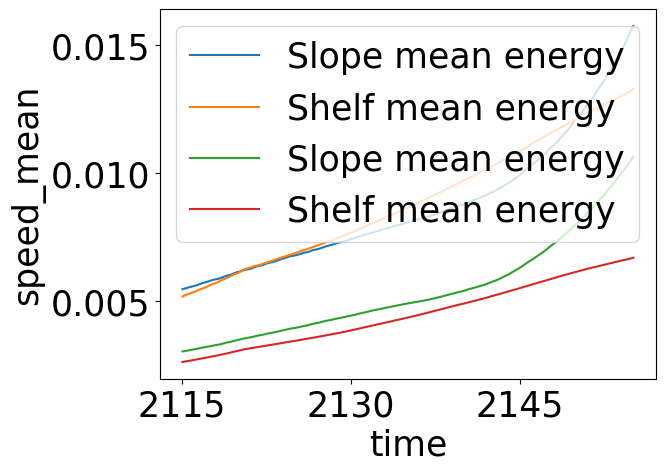

In [86]:
energy_mean_slopex.energy_mean.plot(label = 'Slope mean energy')
energy_mean_shelfx.energy_mean.plot(label = 'Shelf mean energy')
(speed_mean_slopex.speed_mean**2).plot(label = 'Slope mean energy')
(speed_mean_shelfx.speed_mean**2).plot(label = 'Shelf mean energy')
plt.legend()

In [87]:
energy_mean_slopex.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/energy_rolling_MEAN_W' \
                              + str(windows) + '_' + expt+ '_slope.nc')
energy_mean_shelfx.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/energy_rolling_MEAN_W' \
                              + str(windows) + '_' + expt+ '_shelf.nc')

In [ ]:
#speed_mean_slopex.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/speed_rolling_MEAN_W' \
#                              + str(windows) + '_' + expt+ 'shelf.nc')
#speed_mean_shelfx.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/speed_rolling_MEAN_W' \
#                              + str(windows) + '_' + expt+ 'slope.nc')

In [24]:
## eddy

In [98]:
FileList = ['/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_' + expt + '_'+ str(xx_file)\
            + '_' + str(xx) + '.nc' for xx_file in range(4) for xx in range(3)]
FileList

['/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_01deg_jra55v13_ryf9091_qian_wthmp_0_0.nc',
 '/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_01deg_jra55v13_ryf9091_qian_wthmp_0_1.nc',
 '/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_01deg_jra55v13_ryf9091_qian_wthmp_0_2.nc',
 '/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_01deg_jra55v13_ryf9091_qian_wthmp_1_0.nc',
 '/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_01deg_jra55v13_ryf9091_qian_wthmp_1_1.nc',
 '/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_01deg_jra55v13_ryf9091_qian_wthmp_1_2.nc',
 '/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_01deg_jra55v13_ryf9091_qian_wthmp_2_0.nc',
 '/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_01deg_jra55v13_ryf9091_qian_wthmp_2_1.nc',
 '/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_01deg_jra55v13_ryf9091_qian_wthmp_2_2.nc',
 '/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_01deg_jra55v13_ryf9091_qian_wthmp_3_0.nc',
 '/g/data/v45/qo9901/MW-pertur

In [99]:
rho_0 = 1035
eke = np.sqrt(xr.open_mfdataset(FileList, combine = 'by_coords')/0.5/rho_0)
eke = xr.open_mfdataset(FileList, combine = 'by_coords')/0.5/rho_0

eke

<xarray.Dataset> Size: 6GB
Dimensions:                        (yu_ocean: 440, xu_ocean: 3600, time: 481)
Coordinates:
  * yu_ocean                       (yu_ocean) float64 4kB -78.98 ... -60.02
  * xu_ocean                       (xu_ocean) float64 29kB -279.9 ... 80.0
  * time                           (time) object 4kB 2115-01-16 12:00:00 ... ...
    geolon_c                       (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 300), meta=np.ndarray>
    geolat_c                       (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 300), meta=np.ndarray>
Data variables:
    __xarray_dataarray_variable__  (yu_ocean, xu_ocean, time) float64 6GB dask.array<chunksize=(440, 300, 481), meta=np.ndarray>

In [100]:
eddyspeed_t_shelf = grid.integrate(eke.where(cluster_mask_access == True)\
                                   .where(mask_shelf == True), axis = {'X','Y'}).load()/circ_area_shelf
eddyspeed_t_slope = grid.integrate(eke.where(cluster_mask_access == True)\
                                   .where(mask_slope == True), axis = {'X','Y'}).load()/circ_area_slope     

In [101]:
circ_area_shelf

array(2.92146298e+12)

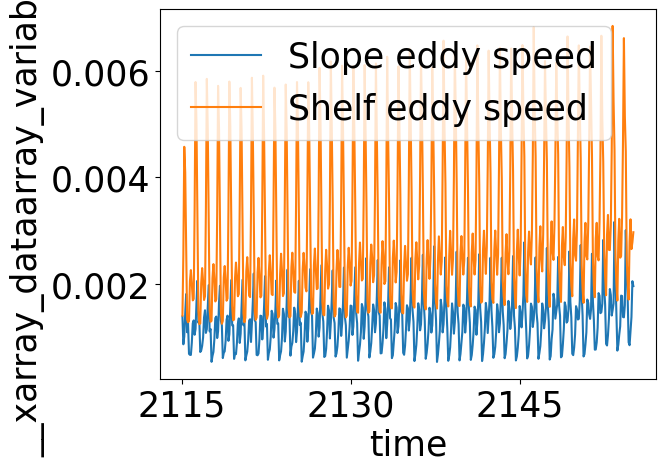

In [102]:
eddyspeed_t_slope.__xarray_dataarray_variable__.plot(label = 'Slope eddy speed')
eddyspeed_t_shelf.__xarray_dataarray_variable__.plot(label = 'Shelf eddy speed')
plt.legend()

In [55]:
%%time
#u_transient_clim = u.isel(xu_ocean = slice(xx*300 + 900*xx_file, (xx+1)*300+ 900*xx_file)) - u_reshape.isel(xu_ocean = slice(xx*300, (xx+1)*300))
#v_transient_clim = v.isel(xu_ocean = slice(xx*300+ 900*xx_file, (xx+1)*300+ 900*xx_file)) - v_reshape.isel(xu_ocean = slice(xx*300, (xx+1)*300))
energy_uup_vvp_slopematrix =[]
energy_uup_vvp_shelfmatrix = []
for tt in range(1):
    ushape = u_reshape.isel(time = slice(tt*chunksize, (tt+1)*chunksize))
    vshape = v_reshape.isel(time = slice(tt*chunksize, (tt+1)*chunksize))
    
    u_transient_clim = u.isel(time = slice(60+tt*chunksize, 60+(tt+1)*chunksize)) - \
                        u_reshape.isel(time = slice(tt*chunksize, (tt+1)*chunksize))
    v_transient_clim = v.isel(time = slice(60+tt*chunksize, 60+(tt+1)*chunksize)) - \
                        v_reshape.isel(time = slice(tt*chunksize, (tt+1)*chunksize))
    
    print('loading')
    u_transientsel = u_transient_clim.assign_coords(time = v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]).load()#.expand_dims(time = {v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]:chunksize}).load()#.where(mask_bath_shelf == True)
    c.run(gc.collect)
    
    v_transientsel = v_transient_clim.assign_coords(time = v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]).load()#.expand_dims(time = {v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]:chunksize}).load()#.where(mask_bath_shelf == True)
    
    energy_uup_vvp_slope = (ushape*u_transientsel).where(cluster_mask_access == True).where(mask_slope == True) \
                    +  (vshape*v_transientsel).where(cluster_mask_access == True).where(mask_slope == True)
    energy_uup_vvp_slopematrix.append(grid.integrate(energy_uup_vvp_slope, axis = {'X','Y'}).load())
    
    energy_uup_vvp_shelf = (ushape*u_transientsel).where(cluster_mask_access == True).where(mask_shelf == True) \
                    +  (vshape*v_transientsel).where(cluster_mask_access == True).where(mask_shelf == True)
    energy_uup_vvp_shelfmatrix.append(grid.integrate(energy_uup_vvp_shelf, axis = {'X','Y'}).load())
    
    del energy_uup_vvp_slope, energy_uup_vvp_shelf
    print('tt = ' + str(tt))


loading
tt = 0
CPU times: user 6.13 s, sys: 2.22 s, total: 8.35 s
Wall time: 22.5 s


In [57]:
u_reshape

<xarray.DataArray '__xarray_dataarray_variable__' (yu_ocean: 440,
                                                   xu_ocean: 3600, time: 481)> Size: 6GB
dask.array<concatenate, shape=(440, 3600, 481), dtype=float64, chunksize=(440, 900, 481), chunktype=numpy.ndarray>
Coordinates:
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * time      (time) object 4kB 2115-01-16 12:00:00 ... 2155-01-16 12:00:00

In [56]:
ushape, u_transient_clim

(<xarray.DataArray '__xarray_dataarray_variable__' (yu_ocean: 440,
                                                    xu_ocean: 3600, time: 13)> Size: 165MB
 dask.array<getitem, shape=(440, 3600, 13), dtype=float64, chunksize=(440, 900, 13), chunktype=numpy.ndarray>
 Coordinates:
   * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
   * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
   * time      (time) object 104B 2115-01-16 12:00:00 ... 2116-01-16 12:00:00,
 <xarray.DataArray (yu_ocean: 440, xu_ocean: 3600, time: 13)> Size: 165MB
 dask.array<sub, shape=(440, 3600, 13), dtype=float64, chunksize=(440, 900, 13), chunktype=numpy.ndarray>
 Coordinates:
   * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
   * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
     geolon_c  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 3600), meta=np.ndarray>
     geolat_c  (yu_ocean, xu_ocean

In [57]:
energy_uup_vvp_shelfmatrix[0].rename_vars({'__xarray_dataarray_variable__':'speed_mean'})

<xarray.Dataset> Size: 208B
Dimensions:     (time: 13)
Coordinates:
  * time        (time) object 104B 2115-01-16 12:00:00 ... 2116-01-16 12:00:00
Data variables:
    speed_mean  (time) float64 104B -1.902e+09 4.597e+09 ... -1.238e+09

In [59]:
energy_uup_vvp_slopex = xr.merge([energy_uup_vvp_slopematrix[i].rename_vars({'__xarray_dataarray_variable__':'energy_mean'}) for i in np.arange(int(len(energy_uup_vvp_slopematrix)))])/circ_area_slope        
energy_uup_vvp_shelfx = xr.merge([energy_uup_vvp_shelfmatrix[i].rename_vars({'__xarray_dataarray_variable__':'energy_mean'}) for i in np.arange(int(len(energy_uup_vvp_shelfmatrix)))])/circ_area_shelf                                 

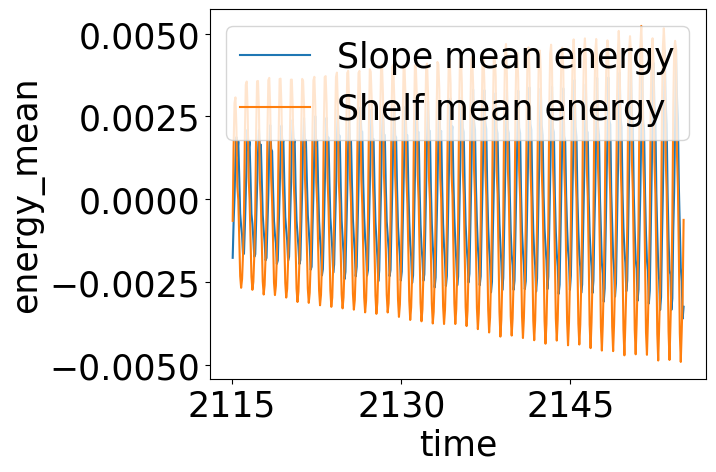

In [60]:
energy_uup_vvp_slopex.energy_mean.plot(label = 'Slope cross energy')
energy_uup_vvp_shelfx.energy_mean.plot(label = 'Shelf cross energy')
plt.legend()

In [61]:
#energy_uup_vvp_slopex.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/speed2_rolling_uup_vvp_W' \
#                              + str(windows) + '_' + expt+ 'shelf.nc')
#energy_uup_vvp_shelfx.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/speed2_rolling_uup_vvp_W' \
#                              + str(windows) + '_' + expt+ 'slope.nc')

In [71]:
## for total speed
chunksize = 30

In [38]:
%%time
#u_transient_clim = u.isel(xu_ocean = slice(xx*300 + 900*xx_file, (xx+1)*300+ 900*xx_file)) - u_reshape.isel(xu_ocean = slice(xx*300, (xx+1)*300))
#v_transient_clim = v.isel(xu_ocean = slice(xx*300+ 900*xx_file, (xx+1)*300+ 900*xx_file)) - v_reshape.isel(xu_ocean = slice(xx*300, (xx+1)*300))
speed_mean_slopematrix =[]
speed_mean_shelfmatrix = []
for tt in range(20):
    u_transient_clim = u.isel(time = slice(tt*chunksize, (tt+1)*chunksize))
    v_transient_clim = v.isel(time = slice(tt*chunksize, (tt+1)*chunksize))
    
    print('loading')
    u_transientsel = u_transient_clim.assign_coords(time = u.time.data[slice(tt*chunksize, (tt+1)*chunksize)]).load()#.expand_dims(time = {v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]:chunksize}).load()#.where(mask_bath_shelf == True)
    c.run(gc.collect)
    
    v_transientsel = v_transient_clim.assign_coords(time = v.time.data[slice(tt*chunksize, (tt+1)*chunksize)]).load()#.expand_dims(time = {v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]:chunksize}).load()#.where(mask_bath_shelf == True)
    
    speed_mean_slope = np.sqrt(u_transientsel.where(cluster_mask_access == True).where(mask_slope == True)**2 \
                    +  v_transientsel.where(cluster_mask_access == True).where(mask_slope == True)**2)
    speed_mean_slopematrix.append(grid.integrate(speed_mean_slope, axis = {'X','Y'}).load())
    
    speed_mean_shelf = np.sqrt(u_transientsel.where(cluster_mask_access == True).where(mask_shelf == True)**2 \
                    +  v_transientsel.where(cluster_mask_access == True).where(mask_shelf == True)**2)
    speed_mean_shelfmatrix.append(grid.integrate(speed_mean_shelf, axis = {'X','Y'}).load())
    
    del speed_mean_slope, speed_mean_shelf
    print('tt = ' + str(tt))


loading
tt = 0
loading
tt = 1
loading
tt = 2
loading
tt = 3
loading
tt = 4
loading
tt = 5
loading
tt = 6
loading
tt = 7
loading
tt = 8
loading
tt = 9
loading
tt = 10
loading
tt = 11
loading
tt = 12
loading
tt = 13
loading
tt = 14
loading
tt = 15
loading
tt = 16
loading
tt = 17
loading
tt = 18
loading
tt = 19
CPU times: user 2min 18s, sys: 1min 28s, total: 3min 47s
Wall time: 6min 47s


In [39]:
speed_total_slopex = xr.merge([speed_mean_slopematrix[i].rename_vars({'__xarray_dataarray_variable__':'speed'}) for i in np.arange(int(len(speed_mean_slopematrix)))])/circ_area_slope        
speed_total_shelfx = xr.merge([speed_mean_shelfmatrix[i].rename_vars({'__xarray_dataarray_variable__':'speed'}) for i in np.arange(int(len(speed_mean_shelfmatrix)))])/circ_area_shelf                                 

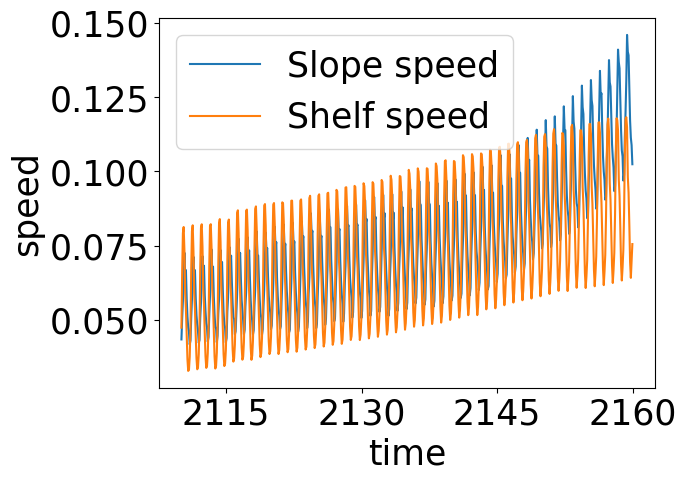

In [40]:
speed_total_slopex.speed.plot(label = 'Slope speed')
speed_total_shelfx.speed.plot(label = 'Shelf speed')
plt.legend()

In [60]:
expt

'01deg_jra55v13_ryf9091_qian_wthmp'

In [41]:
speed_total_shelfx.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/speed2_surf_total_W' \
                              + str(windows) + '_' + expt+ 'shelf.nc')
speed_total_slopex.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/speed2_surf_total_W' \
                              + str(windows) + '_' + expt+ 'slope.nc')

In [77]:
%%time
#u_transient_clim = u.isel(xu_ocean = slice(xx*300 + 900*xx_file, (xx+1)*300+ 900*xx_file)) - u_reshape.isel(xu_ocean = slice(xx*300, (xx+1)*300))
#v_transient_clim = v.isel(xu_ocean = slice(xx*300+ 900*xx_file, (xx+1)*300+ 900*xx_file)) - v_reshape.isel(xu_ocean = slice(xx*300, (xx+1)*300))
energy_mean_slopematrix =[]
energy_mean_shelfmatrix = []
for tt in range(20):
    u_transient_clim = u.isel(time = slice(tt*chunksize, (tt+1)*chunksize))
    v_transient_clim = v.isel(time = slice(tt*chunksize, (tt+1)*chunksize))
    
    print('loading')
    u_transientsel = u_transient_clim.assign_coords(time = u.time.data[slice(tt*chunksize, (tt+1)*chunksize)]).load()#.expand_dims(time = {v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]:chunksize}).load()#.where(mask_bath_shelf == True)
    c.run(gc.collect)
    
    v_transientsel = v_transient_clim.assign_coords(time = v.time.data[slice(tt*chunksize, (tt+1)*chunksize)]).load()#.expand_dims(time = {v_reshape.time.data[slice(tt*chunksize, (tt+1)*chunksize)]:chunksize}).load()#.where(mask_bath_shelf == True)
    
    energy_mean_slope = (u_transientsel.where(cluster_mask_access == True).where(mask_slope == True)**2 \
                    +  v_transientsel.where(cluster_mask_access == True).where(mask_slope == True)**2)
    energy_mean_slopematrix.append(grid.integrate(energy_mean_slope, axis = {'X','Y'}).load())
    
    energy_mean_shelf = (u_transientsel.where(cluster_mask_access == True).where(mask_shelf == True)**2 \
                    +  v_transientsel.where(cluster_mask_access == True).where(mask_shelf == True)**2)
    energy_mean_shelfmatrix.append(grid.integrate(energy_mean_shelf, axis = {'X','Y'}).load())
    
    del energy_mean_slope, energy_mean_shelf
    print('tt = ' + str(tt))


loading
tt = 0
loading
tt = 1
loading
tt = 2
loading
tt = 3
loading
tt = 4
loading
tt = 5
loading
tt = 6
loading
tt = 7
loading
tt = 8
loading
tt = 9
loading
tt = 10
loading
tt = 11
loading
tt = 12
loading
tt = 13
loading
tt = 14
loading
tt = 15
loading
tt = 16
loading
tt = 17
loading
tt = 18
loading
tt = 19
CPU times: user 2min 36s, sys: 1min 31s, total: 4min 8s
Wall time: 8min


In [78]:
energy_total_slopex = xr.merge([energy_mean_slopematrix[i].rename_vars({'__xarray_dataarray_variable__':'energy'}) for i in np.arange(int(len(energy_mean_slopematrix)))])/circ_area_slope        
energy_total_shelfx = xr.merge([energy_mean_shelfmatrix[i].rename_vars({'__xarray_dataarray_variable__':'energy'}) for i in np.arange(int(len(energy_mean_shelfmatrix)))])/circ_area_shelf                                 

In [79]:
energy_total_slopex

<xarray.Dataset> Size: 10kB
Dimensions:  (time: 600)
Coordinates:
  * time     (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
Data variables:
    energy   (time) float64 5kB 0.003342 0.00464 0.006465 ... 0.01806 0.01631

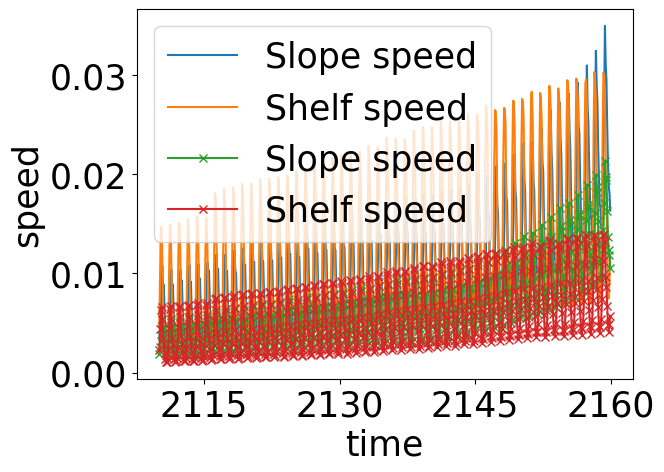

In [80]:
energy_total_slopex.energy.plot(label = 'Slope speed')
energy_total_shelfx.energy.plot(label = 'Shelf speed')
(speed_total_slopex.speed**2).plot(label = 'Slope speed', marker = 'x')
(speed_total_shelfx.speed**2).plot(label = 'Shelf speed', marker = 'x')
plt.legend()

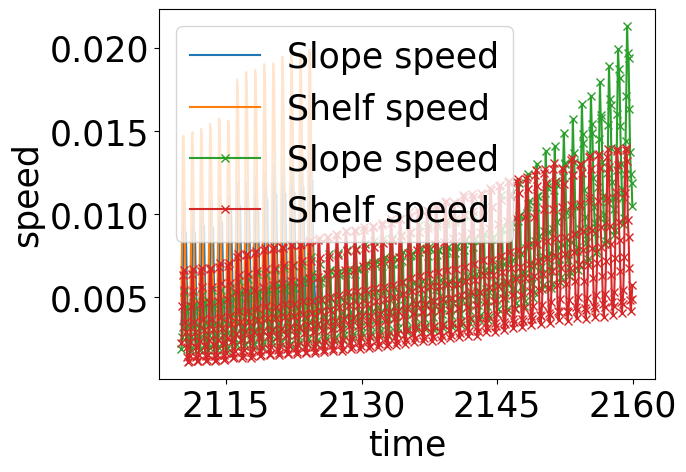

In [75]:
energy_total_slopex.energy.plot(label = 'Slope speed')
energy_total_shelfx.energy.plot(label = 'Shelf speed')
(speed_total_slopex.speed**2).plot(label = 'Slope speed', marker = 'x')
(speed_total_shelfx.speed**2).plot(label = 'Shelf speed', marker = 'x')
plt.legend()

In [ ]:
expt

In [81]:
energy_total_shelfx.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/energy_surf_total_W' \
                              + str(windows) + '_' + expt+ 'shelf.nc')
energy_total_slopex.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/energy_surf_total_W' \
                              + str(windows) + '_' + expt+ 'slope.nc')

In [85]:
eddyspeed_t_slope.time[-1].values

array(cftime.DatetimeNoLeap(2155, 1, 16, 12, 0, 0, 0, has_year_zero=True),
      dtype=object)

In [88]:
### importing to plot
#eddyspeed_t_shelf 
#eddyspeed_t_slope

energy_mean_slopex =  xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/energy_rolling_MEAN_W' \
                              + str(windows) + '_' + expt+ '_slope.nc')
energy_mean_shelfx =  xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/energy_rolling_MEAN_W' \
                              + str(windows) + '_' + expt+ '_shelf.nc')
energy_uup_vvp_shelfx= xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/speed2_rolling_uup_vvp_W' \
                              + str(windows) + '_' + expt+ '_shelfX.nc')
energy_uup_vvp_slopex= xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/speed2_rolling_uup_vvp_W' \
                              + str(windows) + '_' + expt+ '_slopeX.nc')

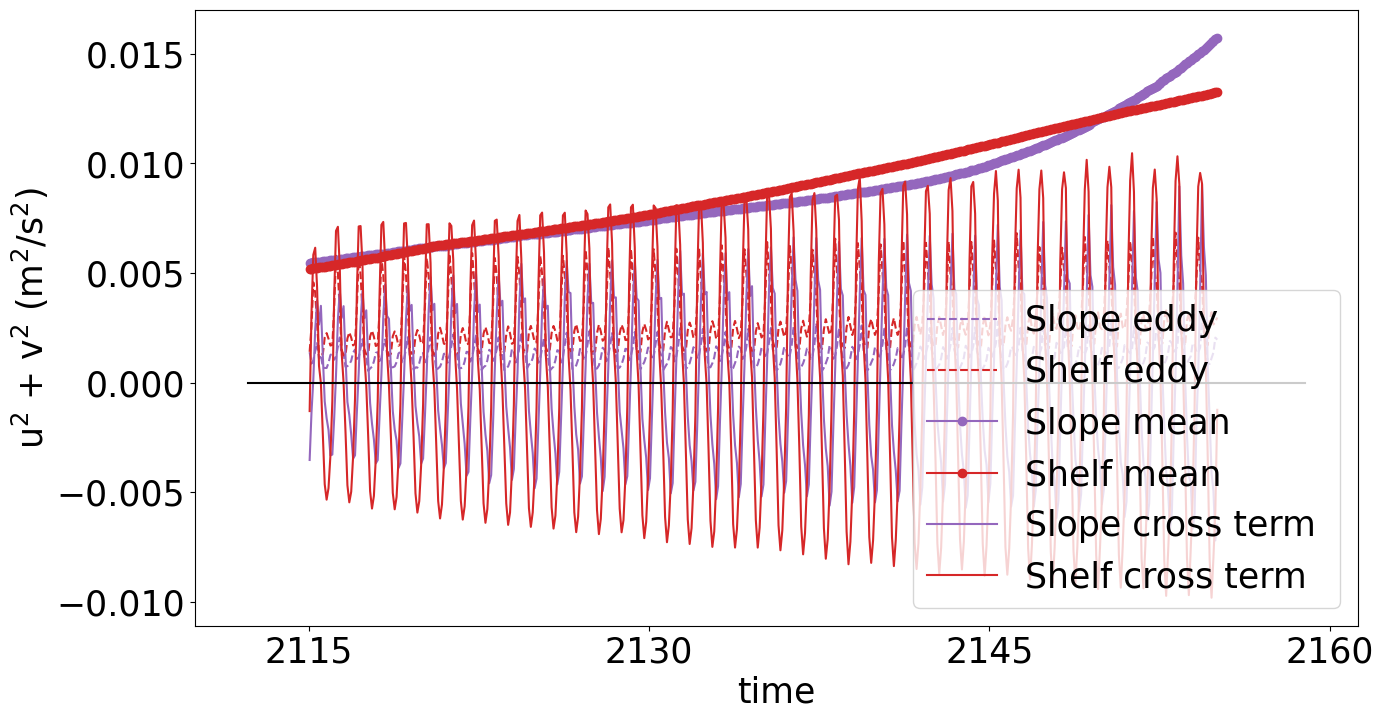

In [107]:
plt.figure(figsize = (15,8))
(eddyspeed_t_slope.__xarray_dataarray_variable__).plot(linestyle = 'dashed',color = 'C4',  label = 'Slope eddy ')
(eddyspeed_t_shelf.__xarray_dataarray_variable__).plot(linestyle = 'dashed', color = 'C3', label = 'Shelf eddy ')
(energy_mean_slopex.energy_mean).plot(marker = 'o', color = 'C4', label = 'Slope mean ')
(energy_mean_shelfx.energy_mean).plot(marker = 'o',color = 'C3',  label = 'Shelf mean ')
(2*energy_uup_vvp_slopex.energy_mean).plot( color = 'C4', label = 'Slope cross term ')
(2*energy_uup_vvp_shelfx.energy_mean).plot(color = 'C3', label = 'Shelf cross term ')
#(speed_total_slopex.speed**2).plot(color = 'C4',label = 'Slope speed', lw = 3)
#(speed_total_shelfx.speed**2).plot(color = 'C3',label = 'Shelf speed', lw = 3)
plt.ylabel('u$^{2}$ + v$^{2}$ (m$^{2}$/s$^{2}$)')
plt.plot([41000,58000],[0,0], 'k')
plt.legend()

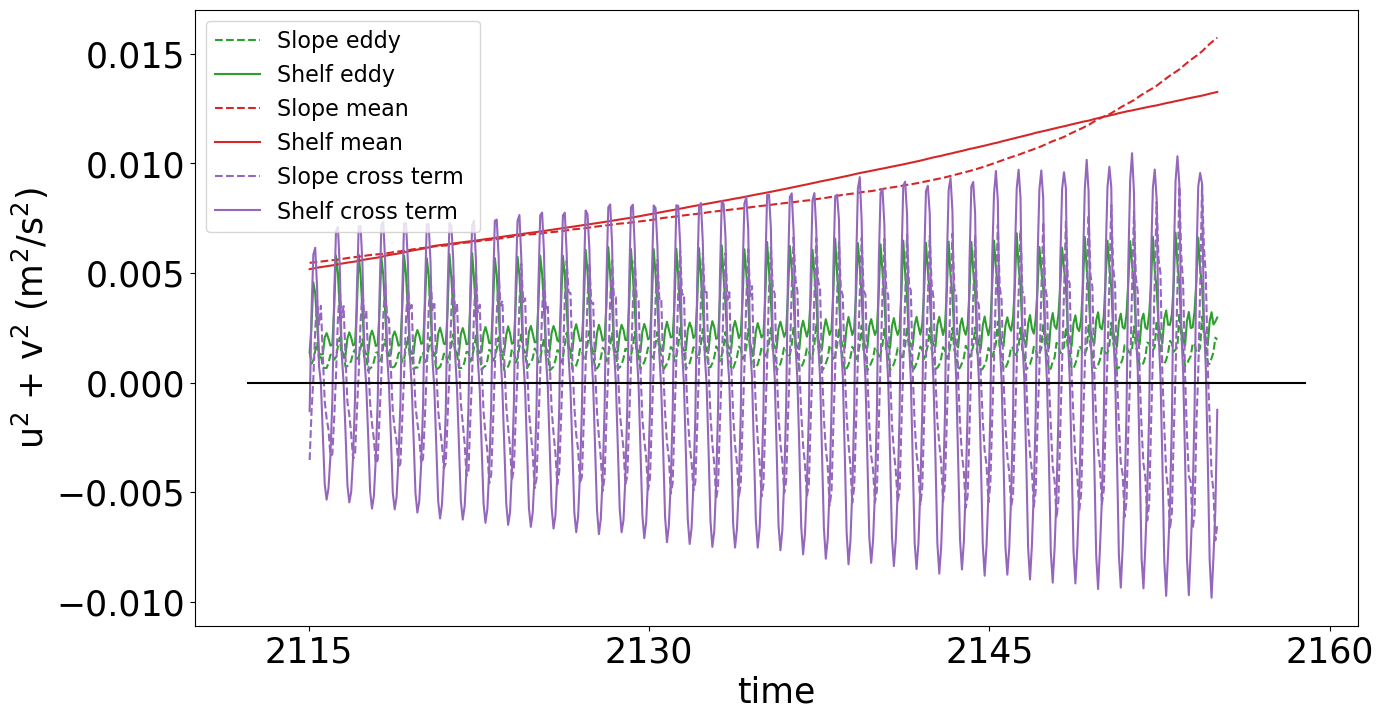

In [121]:
plt.figure(figsize = (15,8))
(eddyspeed_t_slope.__xarray_dataarray_variable__).plot(linestyle = 'dashed',color = 'C2',  label = 'Slope eddy ')
(eddyspeed_t_shelf.__xarray_dataarray_variable__).plot( color = 'C2', label = 'Shelf eddy ')
(energy_mean_slopex.energy_mean).plot(linestyle = 'dashed', color = 'C3', label = 'Slope mean ')
(energy_mean_shelfx.energy_mean).plot(color = 'C3',  label = 'Shelf mean ')
(2*energy_uup_vvp_slopex.energy_mean).plot(linestyle = 'dashed', color = 'C4', label = 'Slope cross term ')
(2*energy_uup_vvp_shelfx.energy_mean).plot(color = 'C4', label = 'Shelf cross term ')
#(speed_total_slopex.speed**2).plot(color = 'C4',label = 'Slope speed', lw = 3)
#(speed_total_shelfx.speed**2).plot(color = 'C3',label = 'Shelf speed', lw = 3)

#(energy_total_slopex.energy).plot(color = 'C0',label = 'Slope energy', linestyle = 'dashed')
#(energy_total_shelfx.energy).plot(color = 'C0',label = 'Shelf energy')

plt.ylabel('u$^{2}$ + v$^{2}$ (m$^{2}$/s$^{2}$)')
plt.plot([41000,58000],[0,0], 'k')
plt.legend(fontsize = 16)

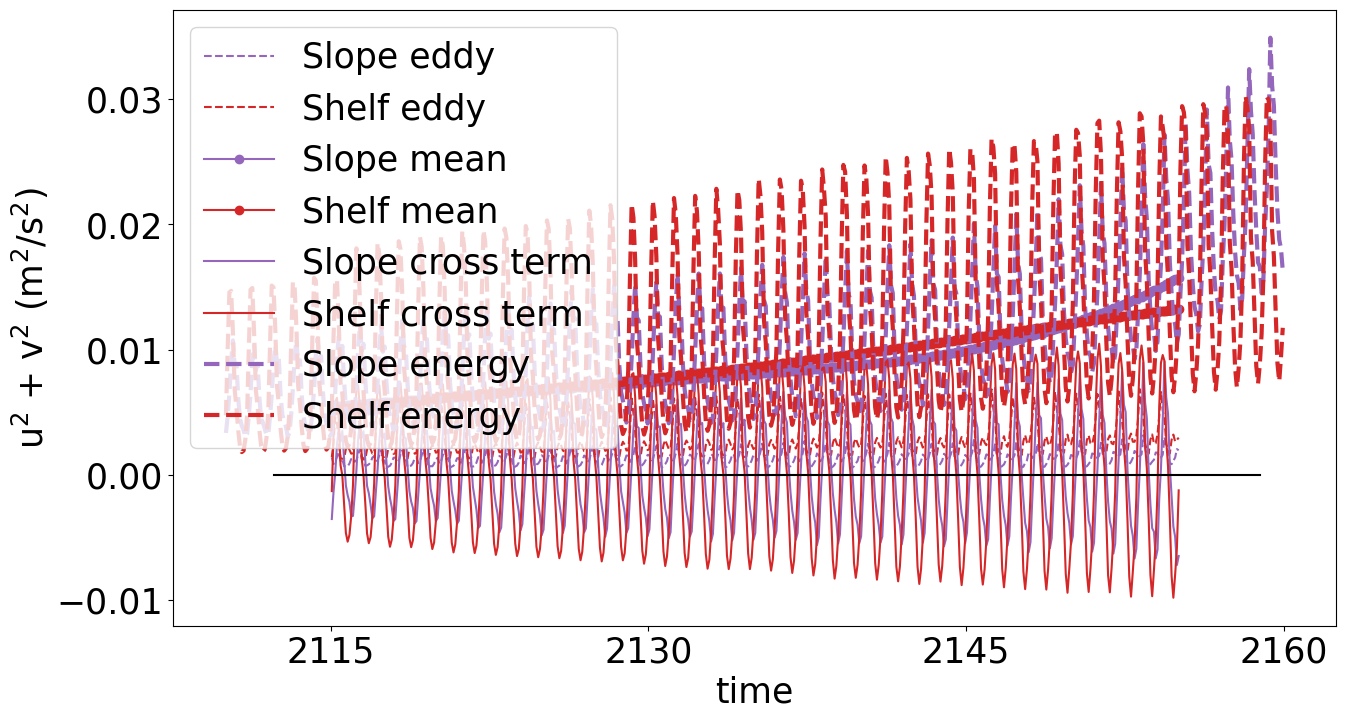

In [112]:
plt.figure(figsize = (15,8))
(eddyspeed_t_slope.__xarray_dataarray_variable__).plot(linestyle = 'dashed',color = 'C4',  label = 'Slope eddy ')
(eddyspeed_t_shelf.__xarray_dataarray_variable__).plot(linestyle = 'dashed', color = 'C3', label = 'Shelf eddy ')
(energy_mean_slopex.energy_mean).plot(marker = 'o', color = 'C4', label = 'Slope mean ')
(energy_mean_shelfx.energy_mean).plot(marker = 'o',color = 'C3',  label = 'Shelf mean ')
(2*energy_uup_vvp_slopex.energy_mean).plot( color = 'C4', label = 'Slope cross term ')
(2*energy_uup_vvp_shelfx.energy_mean).plot(color = 'C3', label = 'Shelf cross term ')
#(speed_total_slopex.speed**2).plot(color = 'C4',label = 'Slope speed', lw = 3)
#(speed_total_shelfx.speed**2).plot(color = 'C3',label = 'Shelf speed', lw = 3)
plt.ylabel('u$^{2}$ + v$^{2}$ (m$^{2}$/s$^{2}$)')
plt.plot([41000,58000],[0,0], 'k')

(energy_total_slopex.energy).plot(color = 'C4',label = 'Slope energy', lw = 3, linestyle = 'dashed')
(energy_total_shelfx.energy).plot(color = 'C3',label = 'Shelf energy', lw = 3,linestyle = 'dashed')
plt.ylabel('u$^{2}$ + v$^{2}$ (m$^{2}$/s$^{2}$)')

plt.legend()

In [104]:
sum_slope = eddyspeed_t_slope.__xarray_dataarray_variable__ + energy_mean_slopex.energy_mean + 2*energy_uup_vvp_slopex.energy_mean
sum_shelf = eddyspeed_t_shelf.__xarray_dataarray_variable__ + energy_mean_shelfx.energy_mean + 2*energy_uup_vvp_shelfx.energy_mean

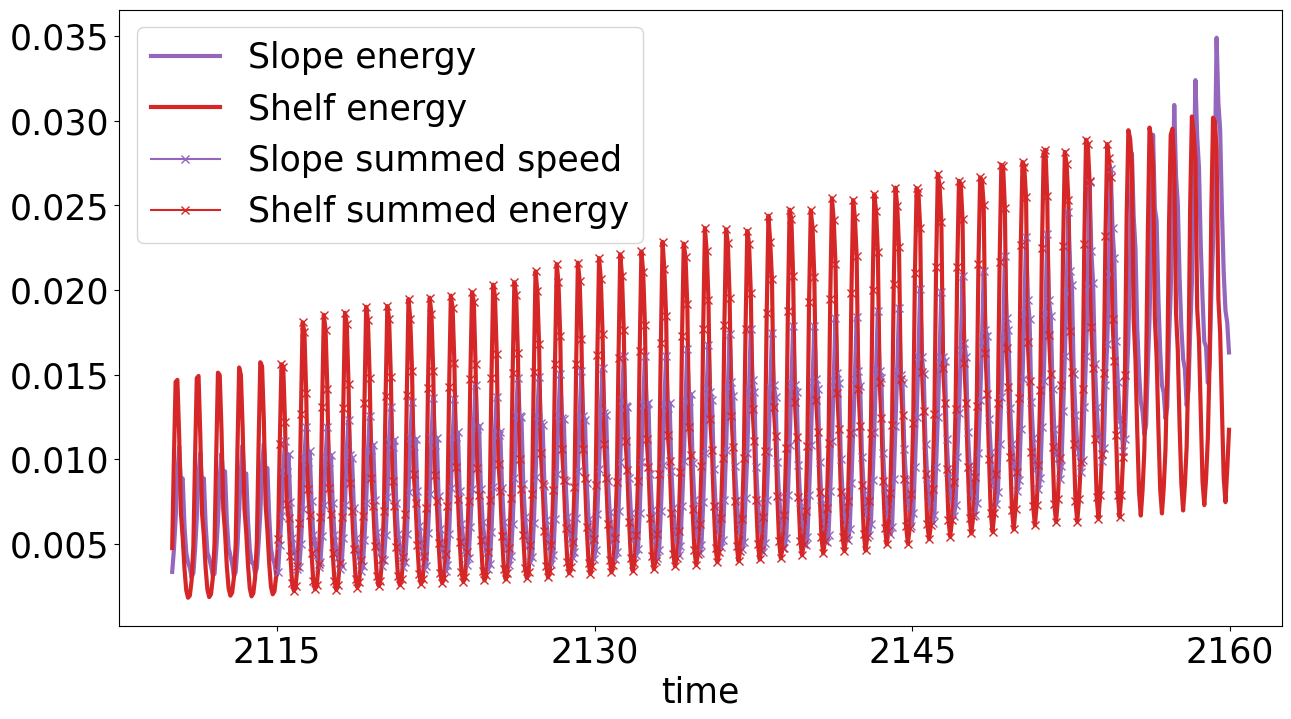

In [105]:
plt.figure(figsize = (15,8))

(energy_total_slopex.energy).plot(color = 'C4',label = 'Slope energy', lw = 3)
(energy_total_shelfx.energy).plot(color = 'C3',label = 'Shelf energy', lw = 3)

sum_slope.plot(color = 'C4',label = 'Slope summed speed', marker = 'x')
sum_shelf.plot(color = 'C3',label = 'Shelf summed energy', marker = 'x')
plt.legend()


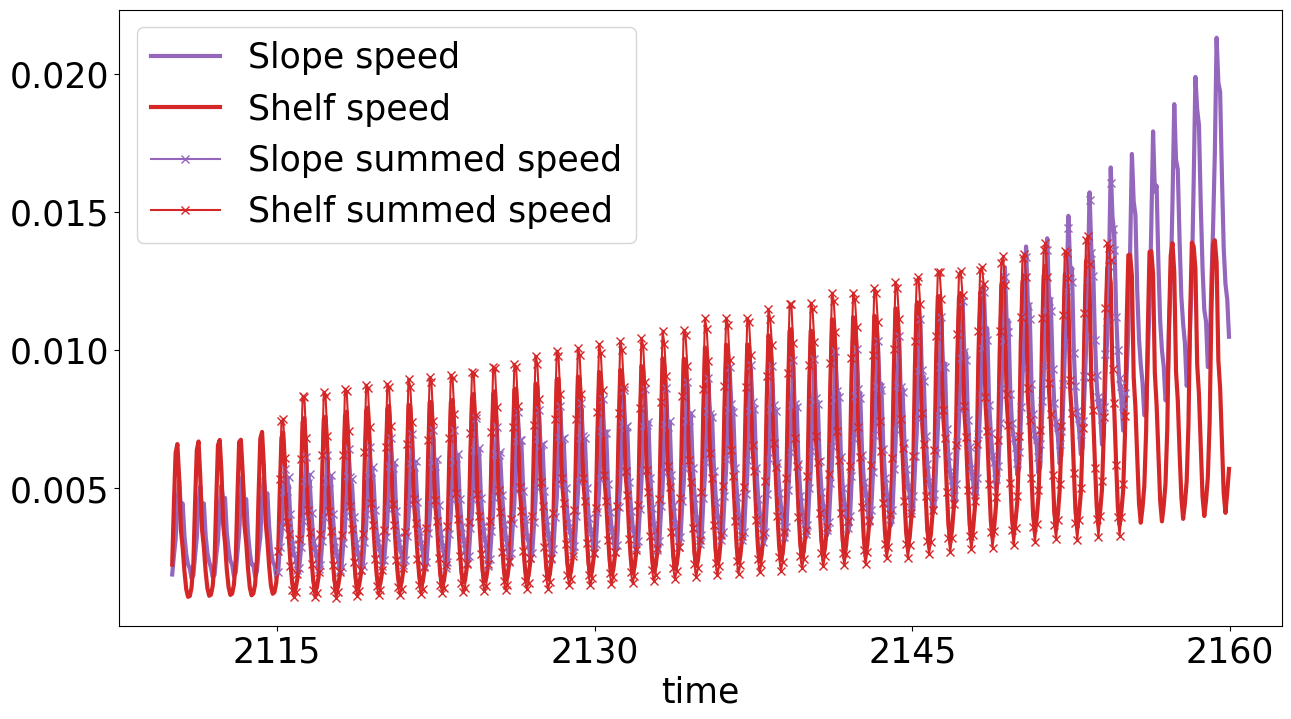

In [78]:
plt.figure(figsize = (15,8))

(speed_total_slopex.speed**2).plot(color = 'C4',label = 'Slope speed', lw = 3)
(speed_total_shelfx.speed**2).plot(color = 'C3',label = 'Shelf speed', lw = 3)

sum_slope.plot(color = 'C4',label = 'Slope summed speed', marker = 'x')
sum_shelf.plot(color = 'C3',label = 'Shelf summed speed', marker = 'x')
plt.legend()

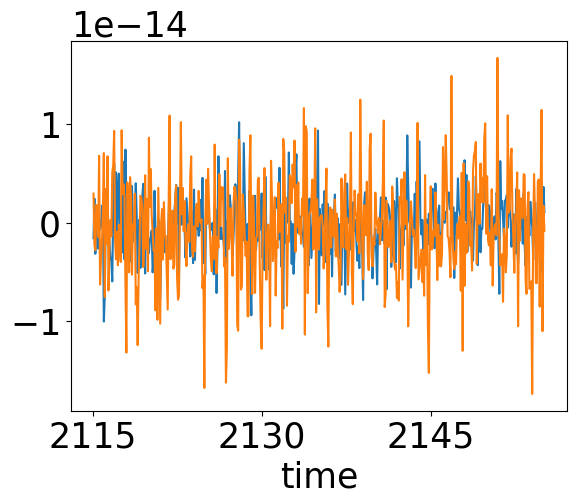

In [106]:
((sum_slope - energy_total_slopex.energy)/energy_total_slopex.energy).plot()
((sum_shelf - energy_total_shelfx.energy)/energy_total_shelfx.energy).plot()